In [1]:
import numpy as np
import pandas as pd
import os
import sys

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 

import pickle
from classifiers.r_method import RMethodClassifier

import seaborn as sns

In [2]:
with open('input_0219_0224_0225_0226_0227_contour_th_128.pkl', 'rb') as f:
    input_all = pickle.load(f)
pixels = input_all[0]
data = input_all[1]

input_all = []
for t in range(5):
    index_d = data.loc[data['source'] == 'source_%s'%t].index.values
    input_d = [[pixels[0][index_d], pixels[1][index_d]], data.loc[index_d]]
    input_all.append(input_d)
input_names = ['0219', '0224', '0225', '0226', '0227', 'all']

In [ ]:
R_0219 = RMethodClassifier(pixels=pixels, truth=data, I0_low=195, I0_high=196, input= 'pixels', method= 'a', const= [5, 20], include_Fe = False)
grade_ths = np.arange(1, 7, 0.5)
all_tuning = []
for grade_th in grade_ths:
    R_0219.tuning(min_recovery_rate=0.95, min_scrap_rate=0.2, A_range=np.arange(0.5, 1.2, 0.01), step_B=0.05, 
                  grade_real_th= grade_th/100.0, score_on=True, score_weight=True, check_metrics=False)
    all_tuning.append(R_0219.tuning_results)

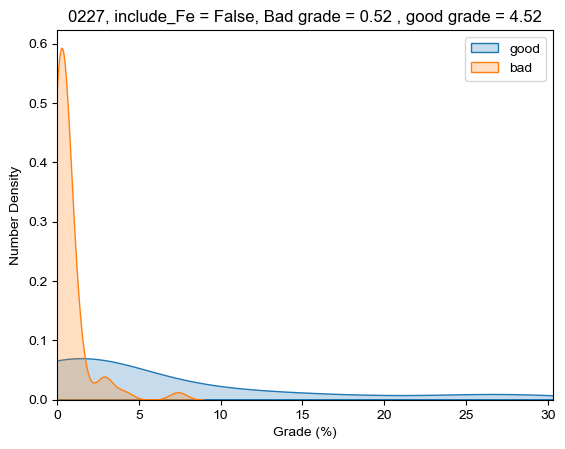

In [ ]:
include_fe = False
for i in range(4, 5):
    R_0219 = RMethodClassifier(pixels=input_all[i][0], truth=input_all[i][1], I0_low=195, I0_high=196, input= 'pixels', method= 'a', const= [5, 20], include_Fe = False)

    index = ((R_0219.R_pixels.apply(np.mean) > 0.70) == True)

    if include_fe:
        fe_good = R_0219.fe_grade[index]
        fe_bad = R_0219.fe_grade[~index]
    else:
        fe_good = 0
        fe_bad = 0

    pb_zn_good = (R_0219.pb_grade[index] + R_0219.zn_grade[index] + fe_good)*100
    good_grade = np.average(R_0219.pb_grade[index] + R_0219.zn_grade[index] + fe_good, weights = R_0219.weight[index])*100
    pb_zn_good_sorted = np.sort(pb_zn_good)

    pb_zn_bad = (R_0219.pb_grade[~index] + R_0219.zn_grade[~index] + fe_bad)*100
    bad_grade = np.average(R_0219.pb_grade[~index] + R_0219.zn_grade[~index] + fe_bad, weights = R_0219.weight[~index])*100
    pb_zn_bad_sorted = np.sort(pb_zn_bad)

    plt.figure()
    plt.xlim(0, pb_zn_good.max())
    sns.kdeplot(pb_zn_good_sorted, label='good', fill=True)
    sns.kdeplot(pb_zn_bad_sorted, label='bad', fill=True)
    plt.legend()
    plt.ylabel('Number Density')
    plt.xlabel('Grade (%)')
    plt.title('%s, include_Fe = %s, Bad grade = %.2f , good grade = %.2f' % (input_names[i], include_fe, bad_grade, good_grade))

交点: [-0.9419907781593121, 1.7094029391627708]


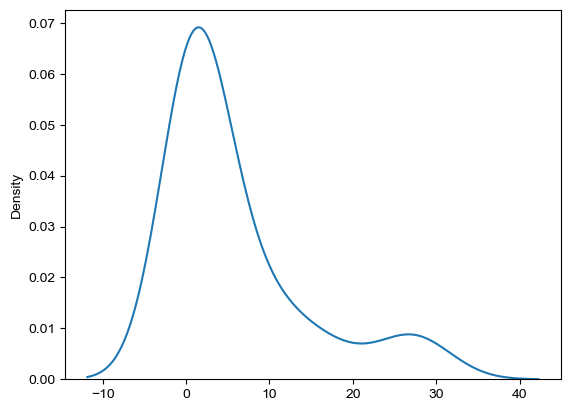

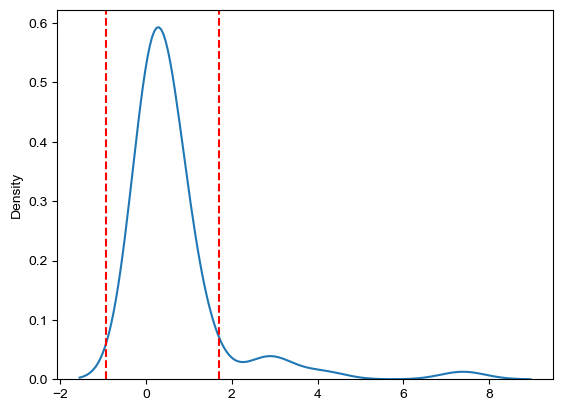

In [114]:
from scipy.interpolate import interp1d
from scipy.optimize import brentq

# 生成KDE曲线
kde_good = sns.kdeplot(pb_zn_good_sorted, label='good', fill=False)

# 获取KDE曲线的数据
x_good, y_good = kde_good.get_lines()[0].get_data()
plt.figure()
kde_bad = sns.kdeplot(pb_zn_bad_sorted, label='bad', fill=False)
x_bad, y_bad = kde_bad.get_lines()[0].get_data()

# 对KDE曲线进行插值
f_good = interp1d(x_good, y_good, kind='linear', fill_value="extrapolate")
f_bad = interp1d(x_bad, y_bad, kind='linear', fill_value="extrapolate")

# 定义差值函数
def difference(x):
    return f_good(x) - f_bad(x)

# 找到交点
intersection_points = []
for i in range(len(x_good) - 1):
    if difference(x_good[i]) * difference(x_good[i + 1]) < 0:
        intersection = brentq(difference, x_good[i], x_good[i + 1])
        intersection_points.append(intersection)

# 打印交点
print("交点:", intersection_points)

# 在图中标记交点
for point in intersection_points:
    plt.axvline(x=point, color='red', linestyle='--', label='交点' if point == intersection_points[0] else "")

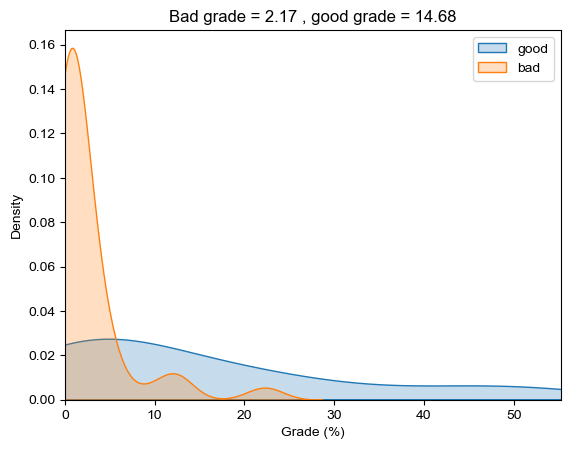

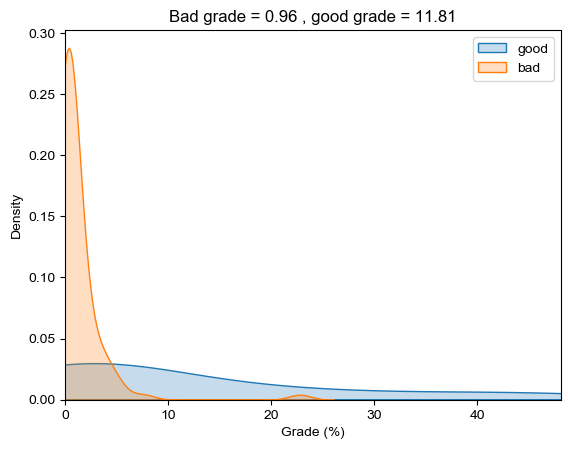

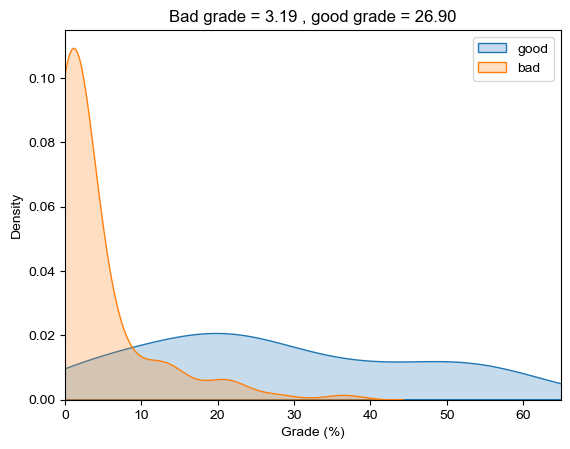

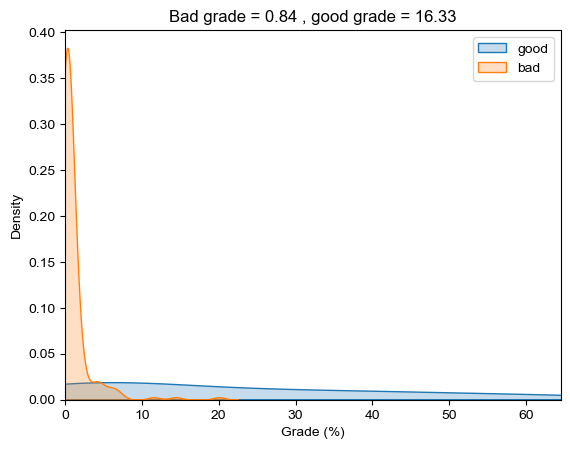

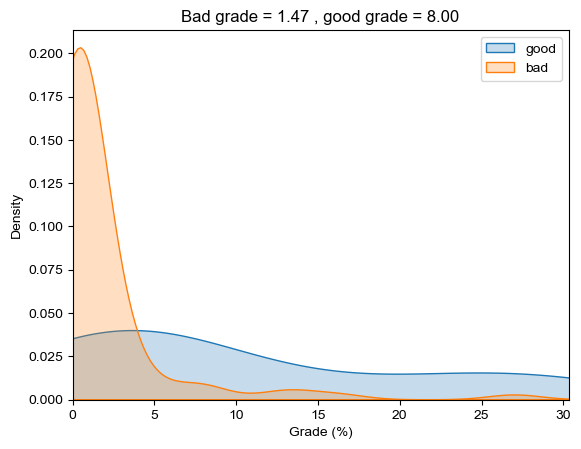

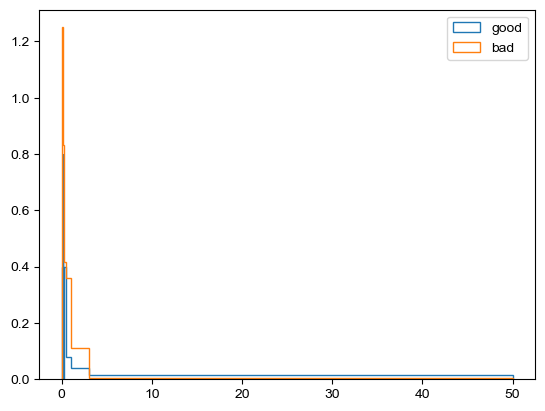

In [44]:
plt.hist(pb_zn_good_sorted, label = 'good', histtype='step', density=True, bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 3, 50]) 
plt.hist(pb_zn_bad_sorted, label = 'bad', histtype='step', density=True, bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 3, 50])
plt.legend()

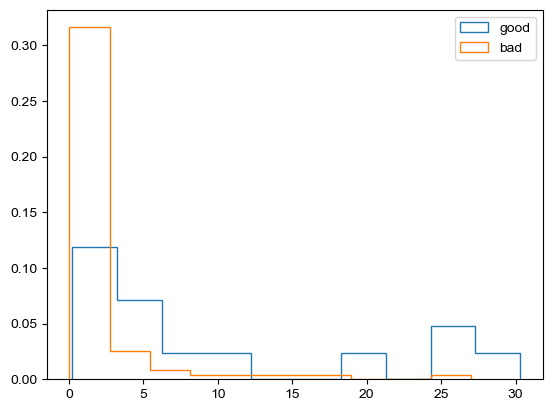

In [80]:
plt.hist(pb_zn_good_sorted, label = 'good', histtype='step', density = True) 
plt.hist(pb_zn_bad_sorted, label = 'bad', histtype='step', density = True)
plt.legend()